In [140]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sklearn Imports
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

# NLTK Imports
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

import warnings

warnings.filterwarnings("ignore")

In [141]:
df = pd.read_csv("../clean_data/clean_combined.csv")
df.shape

(3149, 5)

In [142]:
df['subreddit'].value_counts(normalize=True)

subreddit
Depression    0.542712
Anxiety       0.457288
Name: proportion, dtype: float64

In [143]:
# binarize the target column
df['subreddit'] = df['subreddit'].map({'Depression': 0, 'Anxiety': 1}).astype('Int64')

### Text Pre-Processing

In [144]:
def preprocess(sentence):
    tokenizer = RegexpTokenizer(r"\w+")
    stop_words = stopwords.words("english")
    p_stemmer = PorterStemmer()
    
    tokenized = tokenizer.tokenize(sentence)
    no_stop_words = [word for word in tokenized if word.lower() not in stop_words]
    stemmed = [p_stemmer.stem(word) for word in no_stop_words]
    processed = " ".join(stemmed)

    return processed

In [145]:
df['text_processed'] = df['text'].apply(preprocess)

### Create X and y variables

In [146]:
X = df['text_processed']
y = df['subreddit']

In [147]:
# Dict for model scores
scores = {'model':'score'}

### Train / Test Split

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify= y)

## Pipeline with CountVectorizer and LogisticRegression

In [149]:
pipe = Pipeline([("cvec", CountVectorizer()), ("lr", LogisticRegression(random_state=42))])

pipe_params = {
    "cvec__max_features": [2000],
    "cvec__stop_words": [None, "english"],
    "cvec__min_df": [1],
    "cvec__max_df": [0.5],
    "lr__penalty": ["l1", "l2", "elasticnet", None],
    "lr__class_weight": [None, "balanced"],
    "lr__C": [10.0],
}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=10, n_jobs=-1)

gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.8582827420476823
{'cvec__max_df': 0.5, 'cvec__max_features': 2000, 'cvec__min_df': 1, 'cvec__stop_words': 'english', 'lr__C': 10.0, 'lr__class_weight': None, 'lr__penalty': 'l2'}


In [150]:
pred = gs.predict(X_test)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

0.9948392219134577
0.8793650793650793


In [151]:
scores.update({"CountVectorizer and LogisticRegression": gs.score(X_test, y_test)})

In [152]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
fp, fn

(32, 44)

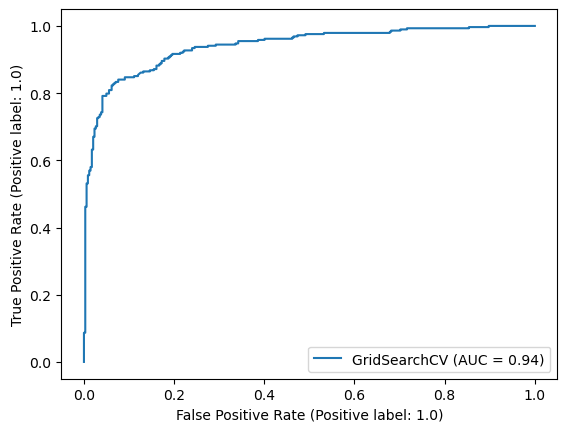

In [153]:
RocCurveDisplay.from_estimator(gs, X_test, y_test);

## Pipeline with TfidfVectorizer and LogisticRegression

In [154]:
pipe = Pipeline([("tfidf", TfidfVectorizer()), ("lr", LogisticRegression(random_state=42))])

pipe_params = {
    "tfidf__max_features": [None],
    "tfidf__stop_words": [None, "english"],
    "tfidf__min_df": [2],
    "tfidf__max_df": [0.8],
    "tfidf__ngram_range": [(1, 3)],
    "lr__penalty": ["l1", "l2", "elasticnet", None],
    "lr__class_weight": [None, "balanced"],
    "lr__C": [10.0],
}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=10, n_jobs=-1)

gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.8920192246885474
{'lr__C': 10.0, 'lr__class_weight': 'balanced', 'lr__penalty': 'l2', 'tfidf__max_df': 0.8, 'tfidf__max_features': None, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 3), 'tfidf__stop_words': 'english'}


In [155]:
pred = gs.predict(X_test)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

0.9944422389837237
0.9142857142857143


In [156]:
scores.update({"TfidfVectorizer and LogisticRegression": gs.score(X_test, y_test)})

In [157]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
fp, fn

(20, 34)

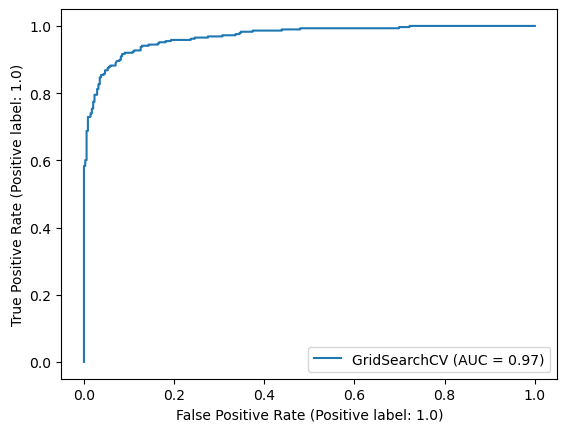

In [158]:
RocCurveDisplay.from_estimator(gs, X_test, y_test);

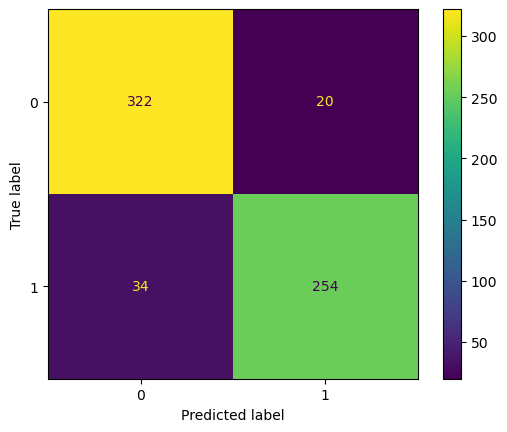

In [159]:
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test);

## Pipeline with CountVectorizer and KNeighborsClassifier

In [160]:
pipe = Pipeline([("cvec", CountVectorizer()), ("knn", KNeighborsClassifier())])

pipe_params = {
    "cvec__max_features": [2000],
    "cvec__stop_words": [None, "english"],
    "cvec__min_df": [1],
    "cvec__max_df": [0.5],
    "knn__n_neighbors": range(3, 10, 2),
}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=10, n_jobs=-1)

gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.7331973692531462
{'cvec__max_df': 0.5, 'cvec__max_features': 2000, 'cvec__min_df': 1, 'cvec__stop_words': 'english', 'knn__n_neighbors': 9}


In [161]:
pred = gs.predict(X_test)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

0.8265184597062326
0.7444444444444445


In [162]:
scores.update({"CountVectorizer and KNeighborsClassifier": gs.score(X_test, y_test)})

In [163]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
fp, fn

(62, 99)

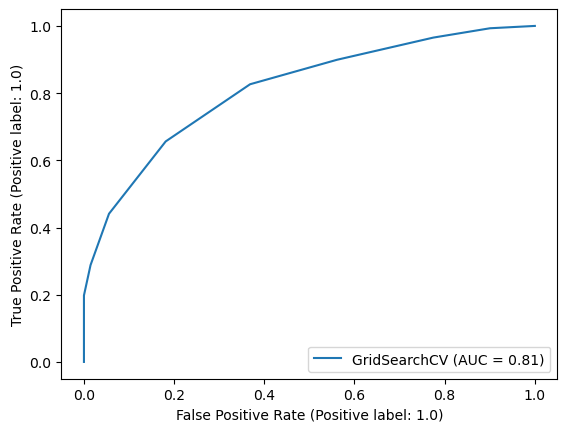

In [164]:
RocCurveDisplay.from_estimator(gs, X_test, y_test);

## Pipeline with CountVectorizer and Bernoulli Naive Bayes

In [165]:
pipe = Pipeline([("cvec", CountVectorizer()), ("bnb", BernoulliNB())])

pipe_params = {
    "cvec__max_features": [2000],
    "cvec__stop_words": [None, "english"],
    "cvec__min_df": [1],
    "cvec__max_df": [0.5],
}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=10, n_jobs=-1)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.8408192626320116
{'cvec__max_df': 0.5, 'cvec__max_features': 2000, 'cvec__min_df': 1, 'cvec__stop_words': 'english'}


In [166]:
pred = gs.predict(X_test)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

0.8654227868201667
0.8650793650793651


In [167]:
scores.update({"CountVectorizer and BernoulliNB": gs.score(X_test, y_test)})

In [168]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
fp, fn

(46, 39)

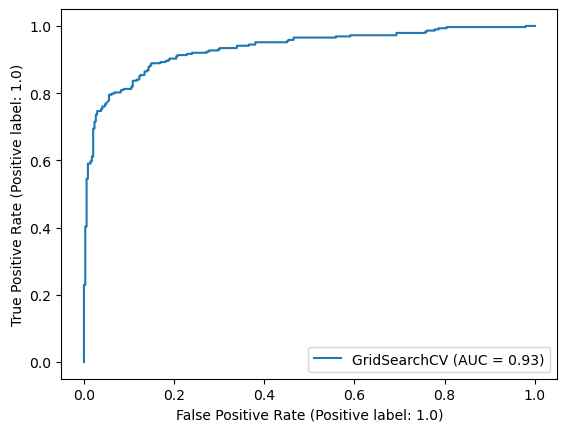

In [169]:
RocCurveDisplay.from_estimator(gs, X_test, y_test);

## Pipeline with TfidfVectorizer and Bernoulli Naive Bayes

In [170]:
pipe = Pipeline([('tfidf', TfidfVectorizer()), ('bnb', BernoulliNB())])

pipe_params = {
    "tfidf__max_features": [None],
    "tfidf__stop_words": [None, "english"],
    "tfidf__min_df": [2],
    "tfidf__max_df": [0.8],
    "tfidf__ngram_range": [(1, 3)],
}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=10, n_jobs=-1)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.8630399038765573
{'tfidf__max_df': 0.8, 'tfidf__max_features': None, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 3), 'tfidf__stop_words': 'english'}


In [171]:
pred = gs.predict(X_test)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

0.9523620484319174
0.8777777777777778


In [172]:
scores.update({"TfidfVectorizer and BernoulliNB": gs.score(X_test, y_test)})

In [173]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
fp, fn

(29, 48)

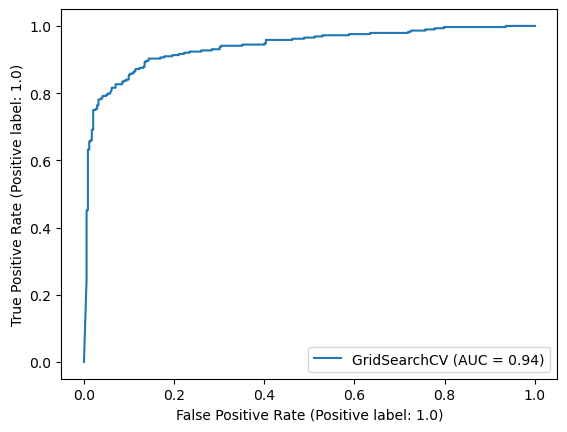

In [174]:
RocCurveDisplay.from_estimator(gs, X_test, y_test);

## Pipeline with TfidfVectorizer and RandomForestClassifier

In [175]:
pipe = Pipeline([("tfidf", TfidfVectorizer()), ("rfc", RandomForestClassifier(random_state=42))])

pipe_params = {
    "tfidf__max_features": [None],
    "tfidf__stop_words": [None, "english"],
    "tfidf__min_df": [2],
    "tfidf__max_df": [0.8],
    "tfidf__ngram_range": [(1, 3)],
}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=10, n_jobs=-1)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.8650271928160373
{'tfidf__max_df': 0.8, 'tfidf__max_features': None, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 3), 'tfidf__stop_words': 'english'}


In [176]:
pred = gs.predict(X_test)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

0.9960301707026598
0.8841269841269841


In [177]:
scores.update({"TfidfVectorizer and RandomForestClassifier": gs.score(X_test, y_test)})

In [178]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
fp, fn

(17, 56)

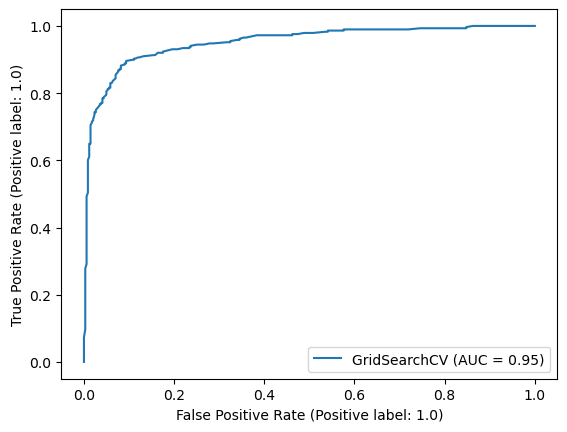

In [179]:
RocCurveDisplay.from_estimator(gs, X_test, y_test);

## Pipeline with TfidfVectorizer and ExtraTreesClassifier

In [180]:
pipe = Pipeline([("tfidf", TfidfVectorizer()), ("rfc", ExtraTreesClassifier(random_state=42))])

pipe_params = {
    "tfidf__max_features": [None],
    "tfidf__stop_words": [None, "english"],
    "tfidf__min_df": [2],
    "tfidf__max_df": [0.8],
    "tfidf__ngram_range": [(1, 3)],
}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=10, n_jobs=-1)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.8654208562575096
{'tfidf__max_df': 0.8, 'tfidf__max_features': None, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 3), 'tfidf__stop_words': None}


In [181]:
pred = gs.predict(X_test)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

0.9960301707026598
0.8920634920634921


In [182]:
scores.update({"TfidfVectorizer and ExtraTreesClassifier": gs.score(X_test, y_test)})

In [183]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
fp, fn

(13, 55)

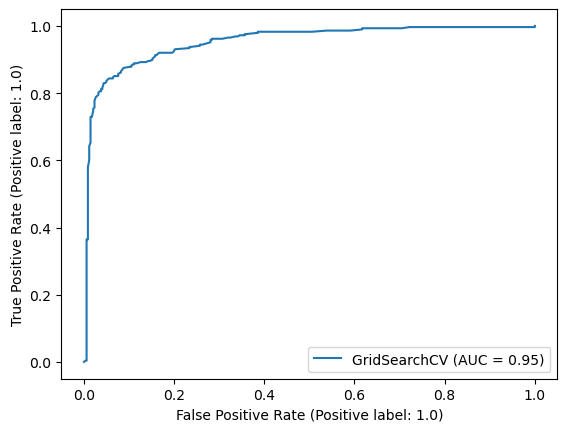

In [184]:
RocCurveDisplay.from_estimator(gs, X_test, y_test);

## Pipeline with CountVectorizer and RandomForestClassifier

In [185]:
pipe = Pipeline([('cvec', CountVectorizer()), ('rfc', RandomForestClassifier(random_state=42))])

pipe_params = {
    "cvec__max_features": [2000],
    "cvec__stop_words": [None, "english"],
    "cvec__min_df": [1],
    "cvec__max_df": [0.5],
}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=10, n_jobs=-1)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.8864652501106685
{'cvec__max_df': 0.5, 'cvec__max_features': 2000, 'cvec__min_df': 1, 'cvec__stop_words': 'english'}


In [186]:
pred = gs.predict(X_test)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

0.9960301707026598
0.9095238095238095


In [187]:
scores.update({"CountVectorizer and RandomForestClassifier": gs.score(X_test, y_test)})

In [188]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
fp, fn

(10, 47)

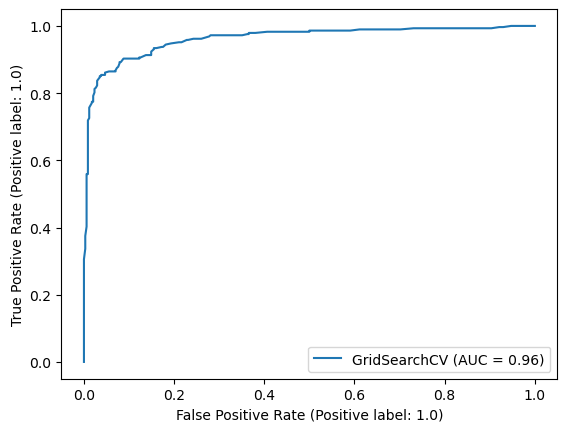

In [189]:
RocCurveDisplay.from_estimator(gs, X_test, y_test);

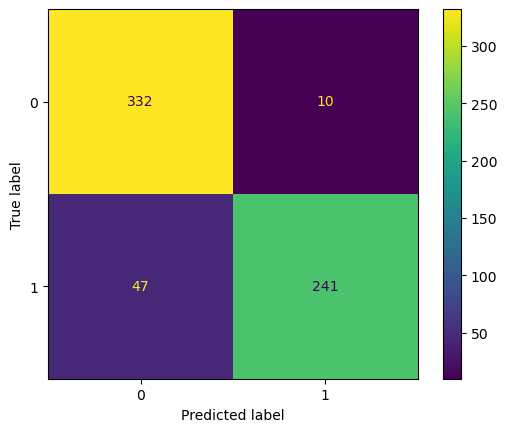

In [190]:
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test);

## Pipeline with CountVectorizer and ExtraTreesClassifier

In [191]:
pipe = Pipeline([('cvec', CountVectorizer()), ('rfc', ExtraTreesClassifier(random_state=42))])

pipe_params = {
    "cvec__max_features": [2000],
    "cvec__stop_words": [None, "english"],
    "cvec__min_df": [1],
    "cvec__max_df": [0.5],
}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=10, n_jobs=-1)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.8832890659583887
{'cvec__max_df': 0.5, 'cvec__max_features': 2000, 'cvec__min_df': 1, 'cvec__stop_words': None}


In [192]:
pred = gs.predict(X_test)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

0.9960301707026598
0.8682539682539683


In [193]:
scores.update({"CountVectorizer and ExtraTreesClassifier": gs.score(X_test, y_test)})

In [194]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
fp, fn

(24, 59)

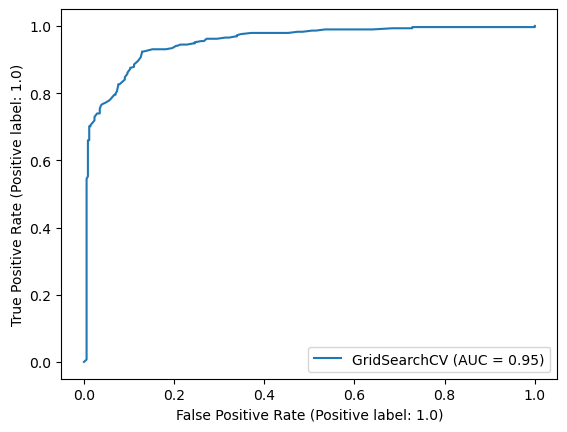

In [195]:
RocCurveDisplay.from_estimator(gs, X_test, y_test);

## Pipeline with CountVectorizer and GradientBoostingClassifier

In [196]:
pipe = Pipeline([("cvec", CountVectorizer()), ("gbc", GradientBoostingClassifier(random_state=42))])

pipe_params = {
    "cvec__max_features": [2000],
    "cvec__stop_words": [None, "english"],
    "cvec__min_df": [1],
    "cvec__max_df": [0.5],
}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=10, n_jobs=-1)

gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.8741573388983748
{'cvec__max_df': 0.5, 'cvec__max_features': 2000, 'cvec__min_df': 1, 'cvec__stop_words': 'english'}


In [197]:
pred = gs.predict(X_test)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

0.9162366018261214
0.8857142857142857


In [198]:
scores.update({"CountVectorizer and GradientBoostingClassifier": gs.score(X_test, y_test)})

In [199]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
fp, fn

(11, 61)

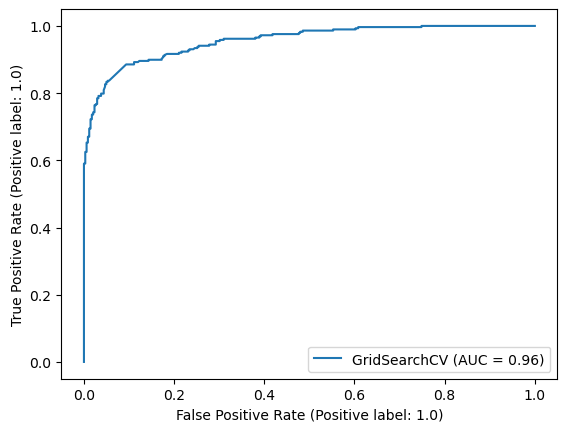

In [200]:
RocCurveDisplay.from_estimator(gs, X_test, y_test);

## Pipeline with TfidfVectorizer and GradientBoostingClassifier

In [201]:
pipe = Pipeline([("tfidf", TfidfVectorizer()), ("gbc", GradientBoostingClassifier(random_state=42))])

pipe_params = {
    "tfidf__max_features": [None],
    "tfidf__stop_words": [None, "english"],
    "tfidf__min_df": [2],
    "tfidf__max_df": [0.8],
    "tfidf__ngram_range": [(1, 3)]
}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=10, n_jobs=-1)

gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.8622446721052299
{'tfidf__max_df': 0.8, 'tfidf__max_features': None, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 3), 'tfidf__stop_words': None}


In [202]:
pred = gs.predict(X_test)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

0.9281460897181422
0.8825396825396825


In [203]:
scores.update({"TfidfVectorizer and GradientBoostingClassifier": gs.score(X_test, y_test)})

In [204]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
fp, fn

(14, 60)

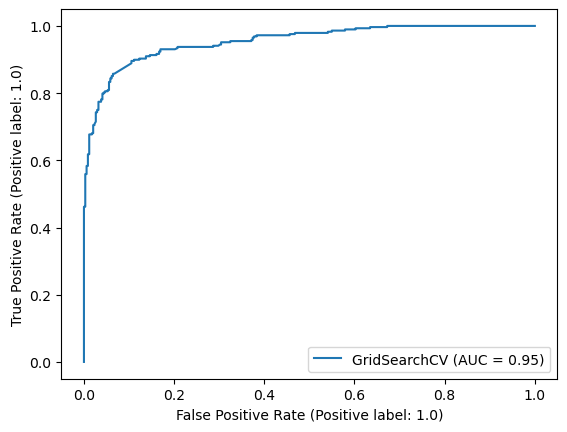

In [205]:
RocCurveDisplay.from_estimator(gs, X_test, y_test);

## Model score visualization comparison

In [206]:
# Save model scores to new dataframe
scores = pd.DataFrame(scores.items())
scores.columns = scores.iloc[0]
scores = scores[1:]
scores.sort_values(by='score', inplace=True)
scores.reset_index(drop=True, inplace=True)
scores.to_csv('../clean_data/model_scores.csv')
scores.head()

,model,score
0,CountVectorizer and KNeighborsClassifier,0.744444
1,CountVectorizer and BernoulliNB,0.865079
2,CountVectorizer and ExtraTreesClassifier,0.868254
3,TfidfVectorizer and BernoulliNB,0.877778
4,CountVectorizer and LogisticRegression,0.879365


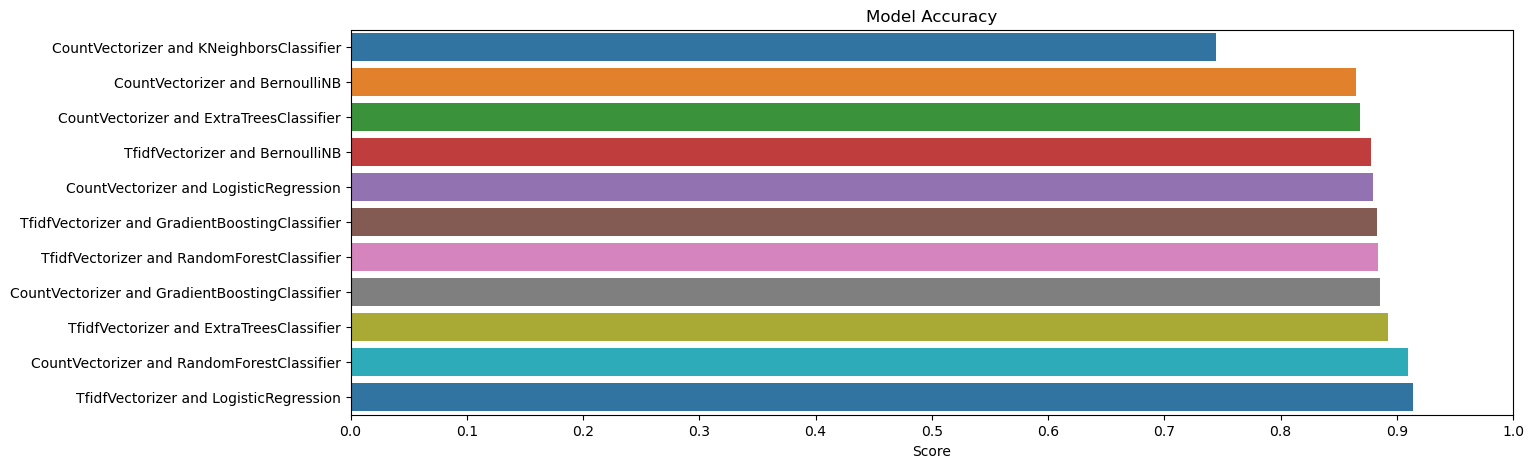

In [207]:
plt.figure(figsize=(15,5))
sns.barplot(data=scores, x='score', y='model', palette='tab10')
plt.title('Model Accuracy')
plt.xlabel('Score')
plt.ylabel(None)
plt.xlim(0.0, 1.0)
plt.xticks(np.arange(0, 1.1, .1))
plt.savefig('../images/model_scores.png', bbox_inches = 'tight')